In [1]:
import numpy as np
from robust_hw import columns, extract_rotations, interpolate, integrate, read_hdf

In [5]:
period = 10

theta_raw = np.unwrap(read_hdf('data/Z-230901A.h5', 'data', columns['theta']))

freq_raw = -1.0 * read_hdf('data/Z-230901A.h5', 'data', 'Sensor1 [Fundamental freq]')
theta_ext, freq_ext = extract_rotations(theta_raw, freq_raw, limits=(np.deg2rad(270), np.deg2rad(390)))
freq_sgn = integrate(freq_ext, np.zeros(freq_ext.size), period)
freq_bgd = interpolate(freq_ext, period, period - 2)
freq_int = integrate(freq_ext, freq_bgd, period)

In [9]:
from robust_hw import create_smoother, initialise, smoothing_step
import jax.numpy as jnp
from tqdm.auto import tqdm

# series of signal - background
theta = theta_ext[::period]
series = freq_int[::period] / freq_int.max()

# results of a training
smoothe_over_signal, smoothe_over_gradient, smoothe_over_variance = 50.0, 55.0, 1.5

#creating a smoother object
smoother = create_smoother(smoothe_over_signal, smoothe_over_gradient, smoothe_over_variance)

# skipping first n_start points and allocating n_warmup points to create an initial state
n_start, n_warmup = 0, int(2 * smoothe_over_signal)

warmup, samples = (jnp.array(series[n_start:n_start + n_warmup]),
                   jnp.array(series[n_start + n_warmup:]))

step = smoothing_step(smoother)

# creating an initial state
state = initialise(smoother, warmup)

# performing real-time smoothing
result = []
for elem in tqdm(samples):
    smoothed, state = step(elem, state)
    result.append(smoothed)

  0%|          | 0/1652 [00:00<?, ?it/s]

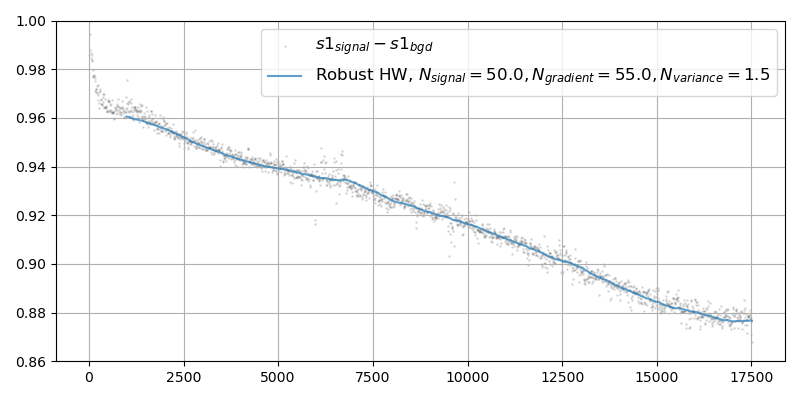

In [10]:
import matplotlib.pyplot as plt

%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(theta, series, s=1, alpha=0.1, c='k', label=r'$s1_{signal} - s1_{bgd}$')
ax.plot(theta[n_start + n_warmup:], result, alpha=0.7,
        label=fr'Robust HW, $N_{{signal}} = {smoothe_over_signal}, '\
              fr'N_{{gradient}} = {smoothe_over_gradient}, '\
              fr'N_{{variance}} = {smoothe_over_variance}$')

ax.legend(fontsize=12)
ax.set_ylim(0.86, 1.0)
ax.grid(True)
fig.tight_layout()
plt.show()